In [1]:
import rpy2
import scipy
import logging
import warnings
import anndata2ri
import collections
import tables
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import decoupler as dc
import scrublet as scr
from scipy import sparse
import scipy.sparse as sp_sparse
import anndata
from anndata import AnnData
from tabnanny import verbose
import matplotlib.pyplot as plt
from gsva_prep import prep_gsva
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from typing import Optional, Union
from matplotlib.pyplot import rcParams
from functions import pathway_analyses
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from rpy2.robjects.conversion import localconverter

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



-----
anndata     0.8.0
scanpy      1.9.1
-----
OpenSSL                     22.0.0
PIL                         9.2.0
absl                        NA
anndata2ri                  1.1
appnope                     0.1.2
asttokens                   NA
astunparse                  1.6.3
attr                        21.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
boto3                       1.26.32
botocore                    1.29.32
bottleneck                  1.3.5
brotli                      NA
certifi                     2022.09.24
cffi                        1.15.1
cloudpickle                 2.2.0
colorama                    0.4.4
cryptography                38.0.1
cycler                      0.10.0
cython_runtime              NA
dask                        2022.11.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
decoupler                   1.4.0
defusedxml                  0.7.1
de

In [4]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# **Load input data in raw form and save in `.h5ad` format**

## **[Grubman et. al. 2019](https://doi.org/10.1038/s41593-019-0539-4) (Entorhinal Cortex (ETC))**

In [3]:
# load AD barcodes

metadata = pd.read_csv("../data/raw/grubman_etc/scRNA_metadata.tsv", sep='\t')
batches = list(metadata.batch.unique())
gene_names = list(pd.read_csv("../data/raw/grubman_etc/mtx/AD1_AD2_genes.tsv", sep="\t", names=['ENS', 'genes'])['genes'])
count_data = sc.read_csv("../data/raw/grubman_etc/scRNA_rawCounts.tsv", delimiter="\t").T

In [4]:
grubman_adata = count_data.copy()
grubman_adata.obs = metadata.copy()

In [5]:
grubman_adata.write_h5ad("../data/raw/grubman_etc/grubman_etc_raw_anndata.h5ad")
del grubman_adata, count_data

## **[Leng et. al. 2021](https://www.synapse.org/#!Synapse:syn21788402/wiki/601825) (Entorhinal Cortex (ETC) and Superior Frontal Gyrus (SFG))**

In [6]:
# processed data obtained 
readRDS = robjects.r['readRDS']
df_etc = readRDS('../data/raw/leng_etc/sce.EC.scAlign.assigned.rds')
adata_leng_etc = df_etc
adata_leng_etc.obs['cell_type'] = adata_leng_etc.obs['clusterCellType'].map({'Exc': 'Excitatory',
                                                                            'Inh': 'Inhibitory',
                                                                            'Astro': 'Astrocyte',
                                                                            'Endo': 'Endothelial', 
                                                                            'Micro': 'Microglia', 
                                                                            'OPC': 'OPC', 
                                                                            'Oligo': 'Oligodendrocyte'})
# processed data obtained 
readRDS = robjects.r['readRDS']
df_sfg = readRDS('../data/raw/leng_sfg/sce.SFG.scAlign.assigned.rds')
adata_leng_sfg = df_sfg
adata_leng_sfg.obs['cell_type'] = adata_leng_sfg.obs['clusterCellType'].map({'Exc': 'Excitatory',
                                                                            'Inh': 'Inhibitory',
                                                                            'Astro': 'Astrocyte',
                                                                            'Endo': 'Endothelial', 
                                                                            'Micro': 'Microglia', 
                                                                            'OPC': 'OPC', 
                                                                            'Oligo': 'Oligodendrocyte'})

adata_leng_etc.write_h5ad('../data/raw/leng_etc/leng_etc_raw_anndata.h5ad')
adata_leng_sfg.write_h5ad('../data/raw/leng_sfg/leng_sfg_raw_anndata.h5ad')
del adata_leng_etc, adata_leng_sfg, df_etc, df_sfg

  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)

  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)



### **Define pathology groups using heirachical clustering of ADNC and CDR scores.**

Individuals are grouped into no, early, and late-pathology groups based on the `AD neuropathological change (ADNC)` score, which represents assessment of amyloid-β deposits (‘A’), staging of neurofibrillary tangles (‘B’) and scoring of neuritic plaques (‘C’) [**Thomas J Montine et al., 2012**](https://pubmed.ncbi.nlm.nih.gov/22101365/), and the `Clinical Dementia rating (CDr)` which reflects the degree of cognitive impairment [**C P Hughes**](https://pubmed.ncbi.nlm.nih.gov/7104545/).

This done to maintain consistency with the clustering used in Mathys et al, where the nine clinico-pathological traits (Supplementary Table 3) where used to group individuals into AD-pathology groups, segregated into two subgroups that correspond to the pathological progression of AD: `‘early-pathology’1 (amyloid burden, but modest neurofibrillary tangles and modest cognitive impairment)`, and `and ‘late-pathology’ (higher amyloid burden, and also increased neurofibrillary tangles, global pathology, and cognitive impairment)`

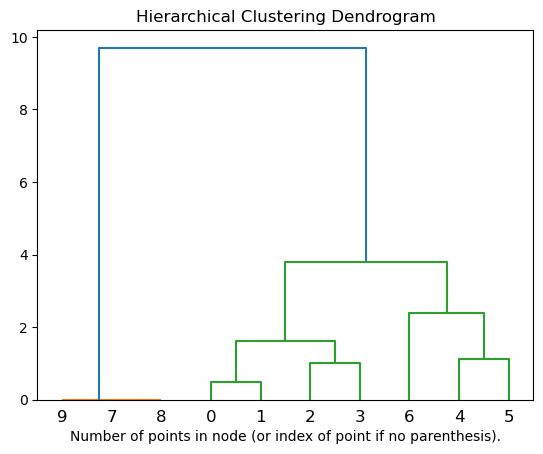

In [25]:

meta = pd.read_csv('../data/raw/leng_etc/leng_etc_metadata.csv')

X = pd.DataFrame()
temp = pd.DataFrame(meta['ADNC_score']).apply(lambda x: x.str.split(','), axis=1, result_type='broadcast')
X["A_score"] = temp.applymap(lambda x: x[0][-1])
X["B_score"] = temp.applymap(lambda x: x[1][-1])
X["C_score"] = temp.applymap(lambda x: x[2][-1])
X['CDR_before_death'] = meta['CDR_before_death']


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## **[Mathys et. al. 2019](https://doi.org/10.1038/s41586-019-1195-2) (Prefrontal Cortex)**

Load filtered data V7 (Local)

In [7]:
# adata_mathys_pfc = sc.read_10x_h5("../data/raw/mathys_pfc_remapped_with_all_samples_using_v7/count/filtered_feature_bc_matrix.h5")

# # adata_mathys_pfc = adata_mathys_pfc[adata_mathys_pfc.X.sum(axis=1)>=200]

# aggregation = pd.read_csv('../data/raw/mathys_pfc_remapped_with_all_samples_using_v7/aggregation.csv')

# aggregation['libraryid'] = aggregation['sample_id'].apply(lambda x: x.split('_')[-1])
# libraryids = list(aggregation.libraryid)
# adata_mathys_pfc.obs['libraryid'] = None


# for ind, val in enumerate(libraryids):
#     adata_mathys_pfc.obs.loc[adata_mathys_pfc.obs.index.str.endswith(f'-{ind+1}'), 'libraryid'] = val

Load filtered data V3 (Local)

In [8]:
# adata_mathys_pfc = sc.read_10x_h5("../data/raw/mathys_pfc_remapped_with_all_samples_using_v3/filtered_feature_bc_matrix.h5")

# # adata_mathys_pfc = adata_mathys_pfc[adata_mathys_pfc.X.sum(axis=1)>=200]

# aggregation = pd.read_csv('../data/raw/mathys_pfc_remapped_with_all_samples_using_v3/aggregation.csv')

# aggregation['libraryid'] = aggregation['library_id'].apply(lambda x: x.split('_')[-1])
# libraryids = list(aggregation.libraryid)
# adata_mathys_pfc.obs['libraryid'] = None


# for ind, val in enumerate(libraryids):
#     adata_.obs.loc[adata_mathys_pfc.obs.index.str.endswith(f'-{ind+1}'), 'libraryid'] = val

Load filtered data V2 (Local)

In [9]:
# #adata_mathys_pfc = sc.read_10x_h5("../data/raw/mathys_pfc_remapped_with_all_samples_using_v2/outs/filtered_gene_bc_matrices_h5.h5")
# adata_mathys_pfc = sc.read_mtx("../data/raw/mathys_pfc_remapped_with_all_samples_using_v2/outs/raw_gene_bc_matrices_mex/GRCh38/matrix.mtx").T
# genes = pd.read_csv("../data/raw/mathys_pfc_remapped_with_all_samples_using_v2/outs/raw_gene_bc_matrices_mex/GRCh38/genes.tsv",
#                      sep="\t", header=None, names=['ENS', 'gene_name'])
# barcodes = pd.read_csv("../data/raw/mathys_pfc_remapped_with_all_samples_using_v2/outs/raw_gene_bc_matrices_mex/GRCh38/barcodes.tsv",
#                      sep="\t", header=None, names=['barcode'])

# adata_mathys_pfc.obs_names = barcodes['barcode'] 
# adata_mathys_pfc.var_names = genes['gene_name']                                  
                     
# aggregation = pd.read_csv('../data/raw/mathys_pfc_remapped_with_all_samples_using_v2/outs/aggregation_csv.csv')

# aggregation['libraryid'] = aggregation['library_id'].apply(lambda x: x.split('_')[-1])
# libraryids = list(aggregation.libraryid)
# adata_mathys_pfc.obs['libraryid'] = None


# for ind, val in enumerate(libraryids):
#     adata_mathys_pfc.obs.loc[adata_mathys_pfc.obs.index.str.endswith(f'-{ind+1}'), 'libraryid'] = val

# new = adata_mathys_pfc.obs.libraryid.str.split("-", n = 1, expand = True)
# adata_mathys_pfc.obs.libraryid = new[1]

# adata_mathys_pfc = adata_mathys_pfc[adata_mathys_pfc.X.sum(1)>=200]

Load filtered data (Mathys)

In [10]:
#adata_mathys_pfc = sc.read_mtx("../data/raw/mathys_pfc/mathys_pfc_count_matrix.mtx").T

adata_mathys_pfc = sc.read_mtx("../data/raw/mathys_pfc/filtered_count_matrix.mtx").T

obs_names = pd.read_csv("../data/raw/mathys_pfc/filtered_column_metadata.txt", sep='\t')
obs_names.set_index('TAG', inplace=True)
obs_names.index.rename('index', inplace=True)
adata_mathys_pfc.obs = obs_names

gene_names = pd.read_csv("../data/raw/mathys_pfc/filtered_gene_row_names.txt", sep='\t', header=None)
adata_mathys_pfc.var_names = gene_names[0]

sample_key = pd.read_csv("../data/raw/mathys_pfc/snRNAseqPFC_BA10_Sample_key.csv")
id_mapping = pd.read_csv("../data/raw/mathys_pfc/snRNAseqPFC_BA10_id_mapping.csv")

merged_key = id_mapping.merge(sample_key, how="outer", on='projid')
merged_key['libraryid'] = merged_key['fastq'].str.split('-').apply(lambda x: x[1].split("_")[0])
merged_key.drop_duplicates(subset='libraryid', keep='first', inplace=True)
merged_key.reset_index(inplace=True)
merged_key.drop('index', axis=1, inplace=True)

adata_mathys_pfc.obs[list(merged_key.columns)] = None

for val in merged_key['sample']:
    adata_mathys_pfc.obs.loc[adata_mathys_pfc.obs.index.str.endswith(f'.{val}'), list(merged_key.columns)] = merged_key[merged_key['sample']==val].values


# main epidemiological and pathological characteristics of the participants
epi_n_patho = pd.read_excel("../data/raw/mathys_pfc/41586_2019_1195_MOESM3_ESM.xlsx", sheet_name=1)

# clinico-pathological variables.
clin_n_patho = pd.read_excel("../data/raw/mathys_pfc/41586_2019_1195_MOESM5_ESM.xlsx", sheet_name=0)

# clinical, epidemiological and pathological metadata
metadata = epi_n_patho.merge(clin_n_patho, how="outer", on="Subject")

# ID mapping from Mathys
mapping = pd.read_csv("../data/raw/mathys_pfc/snRNAseqPFC_BA10_id_mapping.csv", sep=",")
mapping['sampleid'] = mapping['fastq'].str.split('-').apply(lambda x: x[1].split("_")[0])

metadata = metadata.merge(mapping, how='outer', on='Subject').sort_values(by='sampleid')
metadata.drop_duplicates(subset='sampleid', inplace=True)
metadata.reset_index(inplace=True)
metadata.drop('index', axis=1, inplace=True)

sampleids = list(metadata.sampleid.unique())


adata_mathys_pfc.obs[list(metadata.columns)] = None
columns = list(metadata.columns) 

sid = metadata.sampleid.astype(int).min()

for ind, val in enumerate(sampleids):
    adata_mathys_pfc.obs.loc[adata_mathys_pfc.obs.libraryid==val, columns] = metadata[metadata['sampleid']==val].values

adata_mathys_pfc.obs = adata_mathys_pfc.obs.astype('category').copy()

adata_mathys_pfc.obs_names_make_unique()
adata_mathys_pfc.var_names_make_unique()

obs_columns = list(adata_mathys_pfc.obs.columns)
adata_mathys_pfc.obs[obs_columns] = adata_mathys_pfc.obs[obs_columns].astype(str)

var_columns = list(adata_mathys_pfc.var.columns)
adata_mathys_pfc.var[var_columns] = adata_mathys_pfc.var[var_columns].astype(str)

adata_mathys_pfc.obs['cell_type'] = adata_mathys_pfc.obs['broad.cell.type'].map({'Ex': 'Excitatory',
                                                                            'In': 'Inhibitory',
                                                                            'Ast': 'Astrocyte',
                                                                            'End': 'Endothelial', 
                                                                            'Mic': 'Microglia', 
                                                                            'Opc': 'OPC', 
                                                                            'Oli': 'Oligodendrocyte',
                                                                            'Per': 'Pericyte'})

adata_mathys_pfc.write_h5ad('../data/raw/mathys_pfc/mathys_pfc_raw_anndata.h5ad')

del epi_n_patho, clin_n_patho, metadata, mapping, sampleids, merged_key, obs_names, gene_names, adata_mathys_pfc


## **[Human Multiple Cortical Areas SMART-seq reference](https://portal.brain-map.org/atlases-and-data/rnaseq/human-multiple-cortical-areas-smart-seq)**

In [12]:
counts = sc.read_csv('../data/raw/human_multiple_cortical_areas_smart_seq/matrix.csv')
counts = sparse.csr_matrix(counts.X)
adata_reference = AnnData(counts)

del counts

adata_reference.obs = pd.read_csv('../data/raw/human_multiple_cortical_areas_smart_seq/metadata.csv', index_col='sample_name')
adata_reference.var = pd.read_csv('../data/raw/human_multiple_cortical_areas_smart_seq/human_MTG_2018-06-14_genes-rows.csv', index_col='gene')
# adata_reference.obs_names = adata_reference.obs.sample_name.copy()
tsne_cord = pd.read_csv('../data/raw/human_multiple_cortical_areas_smart_seq/tsne.csv')
adata_reference = adata_reference[adata_reference.obs_names.isin(list(tsne_cord.sample_name))]
# adata_reference.obsm['X_tsne'] = tsne_cord[['tsne_1', 'tsne_2']].to_numpy()
adata_reference

View of AnnData object with n_obs × n_vars = 47432 × 50281
    obs: 'exp_component_name', 'specimen_type', 'cluster_color', 'cluster_order', 'cluster_label', 'class_color', 'class_order', 'class_label', 'subclass_color', 'subclass_order', 'subclass_label', 'full_genotype_color', 'full_genotype_order', 'full_genotype_label', 'donor_sex_color', 'donor_sex_order', 'donor_sex_label', 'region_color', 'region_order', 'region_label', 'cortical_layer_color', 'cortical_layer_order', 'cortical_layer_label', 'cell_type_accession_color', 'cell_type_accession_order', 'cell_type_accession_label', 'cell_type_alias_color', 'cell_type_order', 'cell_type_alias_label', 'cell_type_alt_alias_color', 'cell_type_alt_alias_order', 'cell_type_alt_alias_label', 'cell_type_designation_color', 'cell_type_designation_order', 'cell_type_designation_label', 'external_donor_name_color', 'external_donor_name_order', 'external_donor_name_label', 'outlier_call', 'outlier_type'
    var: 'chromosome', 'entrez_id', 'gene_n

In [13]:
obs_columns = list(adata_reference.obs.columns)
adata_reference.obs[obs_columns] = adata_reference.obs[obs_columns].astype(str)

var_columns = list(adata_reference.var.columns)
adata_reference.var[var_columns] = adata_reference.var[var_columns].astype(str)

  adata_reference.obs[obs_columns] = adata_reference.obs[obs_columns].astype(str)



In [14]:
adata_reference.write_h5ad(f'../data/raw/human_multiple_cortical_areas_smart_seq/anndata.h5ad', compression='gzip')

## **[Lau et. al. 2002](https://www.pnas.org/doi/full/10.1073/pnas.2008762117) (Prefrontal Cortex (PTC))**

In [50]:
path_to_dir = '../data/raw/lau_pfc/'
file_list = list(set(['_'.join(file.split('_')[:-1]) for file in os.listdir(path_to_dir)]))

adata_lau_pfc = dict()
for file in file_list:
    adata = sc.read_mtx('../data/raw/lau_pfc/'+file+'_matrix.mtx.gz').T
    barcodes = pd.read_csv('../data/raw/lau_pfc/'+file+'_barcodes.tsv.gz', sep='\t', names=['barcode'], header=None, dtype=str, index_col=0)
    adata.obs = barcodes.astype(str)
    adata.obs['Subject'] = file.split("_")[-1]
    genes = pd.read_csv('../data/raw/lau_pfc/'+file+'_features.tsv.gz', sep='\t', names=['1', 'gene_name', '3'], header=None, dtype=str, index_col=1)
    adata.var = genes.astype(str)
    adata_lau_pfc[file] = adata
    adata_lau_pfc[file].obs_names_make_unique()
    adata_lau_pfc[file].var_names_make_unique()

In [51]:
import anndata
adata_lau_pfc_concat = anndata.concat([adata_lau_pfc[key] for key in adata_lau_pfc.keys()], join='inner')

  utils.warn_names_duplicates("obs")



In [56]:
adata_lau_pfc_concat.write_h5ad('../data/raw/lau_pfc/leng_pfc_raw_anndata.h5ad')

## **[Allen Institute SEA-AD 2023](https://portal.brain-map.org/explore/seattle-alzheimers-disease) (Middle Temporal Gyrus (MTG))**

### **Using Raw Pre-Mapped Data**

In [4]:
biospecimen_metadata = pd.read_csv('../data/raw/SEA-AD/SEA-AD_metadata/SEA-AD_biospecimen_metadata.csv')
biospecimen_metadata = biospecimen_metadata[biospecimen_metadata.assay.str.lower()=='snrnaseq']
individual_metadata = pd.read_csv('../data/raw/SEA-AD/SEA-AD_metadata/SEA-AD_individual_metadata.csv')
manifest = pd.read_csv('../data/raw/SEA-AD/raw_feature_bc_matrices/manifest_1682425120001270000.csv')

all_metadata = manifest.merge(biospecimen_metadata, on='specimenID', how='outer')
all_metadata['individualID'] = all_metadata['individualID_y'] 
all_metadata = all_metadata.merge(individual_metadata, on = 'individualID', how='outer')

all_metadata.columns

Index(['ID', 'name', 'versionNumber', 'contentType', 'dataFileSizeBytes',
       'createdBy', 'createdOn', 'modifiedBy', 'modifiedOn', 'parentId',
       'synapseURL', 'dataFileMD5Hex', 'assay_x', 'consortium', 'dataSubtype',
       'dataType', 'fileFormat', 'grant', 'individualID_x', 'isModelSystem',
       'isMultiSpecimen', 'isMultiome', 'libraryPrep', 'nucleicAcidSource_x',
       'organ_x', 'platform', 'readLength', 'resourceType', 'runType', 'sex_x',
       'species_x', 'specimenID', 'study', 'tissue_x', 'path', 'error',
       'individualID_y', 'specimenIdSource', 'organ_y', 'tissue_y',
       'BrodmannArea', 'sampleStatus', 'tissueWeight', 'tissueVolume',
       'nucleicAcidSource_y', 'cellType', 'fastingState', 'isPostMortem',
       'samplingAge', 'samplingAgeUnits', 'visitNumber', 'assay_y',
       'individualID', 'dataset', 'individualIdSource', 'species_y', 'sex_y',
       'race', 'ethnicity', 'yearsEducation', 'ageDeath', 'causeDeath',
       'mannerDeath', 'apoe4Status',

In [5]:
all_metadata = all_metadata[all_metadata.tissue_x == 'middle temporal gyrus']
all_metadata.to_csv('../data/raw/SEA-AD/SEA-AD_metadata/allen_mtg_metadata.csv')

In [6]:
no_pathology = ["H21.33.003", "H21.33.004", "H21.33.023", "H20.33.044"]
# early_pathology = ["H20.33.015", "H20.33.040", "H21.33.005"]
early_pathology = ["H21.33.044", "H21.33.005"]
# late_pathology = ["H20.33.020", "H20.33.004", "H21.33.029"]
late_pathology = ["H20.33.020", "H21.33.009"]

mapping = {**dict(zip(no_pathology, ["no"]*len(no_pathology))), 
           **dict(zip(early_pathology, ["early"]*len(early_pathology))),
           **dict(zip(late_pathology, ["late"]*len(late_pathology)))}

all_groups = [*no_pathology, *early_pathology, *late_pathology]
filtered_metadata = all_metadata[all_metadata.individualID.isin(all_groups)]
filtered_metadata['pathology.group'] = filtered_metadata.individualID.map(mapping)

/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_12130/2497740083.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata['pathology.group'] = filtered_metadata.individualID.map(mapping)


In [7]:

CountMatrix = collections.namedtuple('CountMatrix', ['feature_ref', 'barcodes', 'matrix'])
 
def get_matrix_from_h5(filename):
    with tables.open_file(filename, 'r') as f:
        mat_group = f.get_node(f.root, 'matrix')
        barcodes = f.get_node(mat_group, 'barcodes').read()
        data = getattr(mat_group, 'data').read()
        indices = getattr(mat_group, 'indices').read()
        indptr = getattr(mat_group, 'indptr').read()
        shape = getattr(mat_group, 'shape').read()
        matrix = sp_sparse.csc_matrix((data, indices, indptr), shape=shape)
         
        feature_ref = {}
        feature_group = f.get_node(mat_group, 'features')
        feature_ids = getattr(feature_group, 'id').read()
        feature_names = getattr(feature_group, 'name').read()
        feature_types = getattr(feature_group, 'feature_type').read()
        feature_ref['id'] = feature_ids
        feature_ref['name'] = feature_names
        feature_ref['feature_type'] = feature_types
        tag_keys = getattr(feature_group, '_all_tag_keys').read()
        for key in tag_keys:
            key = key.decode("utf-8")
            feature_ref[key] = getattr(feature_group, key).read()
         
        return CountMatrix(feature_ref, barcodes, matrix)
 

adatas = []
columns = list(filtered_metadata.columns)

for path in list(filtered_metadata.path)[0:]:

    filtered_matrix_h5 = path
    filtered_feature_bc_matrix = get_matrix_from_h5(filtered_matrix_h5)

    adata = AnnData(filtered_feature_bc_matrix.matrix.T)
    #adata.X = filtered_feature_bc_matrix.matrix
    adata.obs_names = [name.split("-")[0] for name in filtered_feature_bc_matrix.barcodes.astype('U').astype(str)]
    adata.var_names = filtered_feature_bc_matrix.feature_ref['name'].astype('U').astype(str)
    adata.var["id"] = filtered_feature_bc_matrix.feature_ref['id'].astype('U').astype(str)
    adata.var['genome'] = filtered_feature_bc_matrix.feature_ref['genome'].astype('U').astype(str)
    adata.var['feature_type'] = filtered_feature_bc_matrix.feature_ref['feature_type'].astype('U').astype(str)
    adata.obs[columns] = filtered_metadata.loc[filtered_metadata.path == path, columns].iloc[0]

    cell_classes = pd.read_csv(f'../data/raw/SEA-AD/cell_classes/{filtered_metadata.loc[filtered_metadata.path==path, "specimenID"].iloc[0]}.csv')
    cell_classes['barcodes'] = cell_classes['sample_id'].apply(lambda x: x.split("-")[0])

    adata = adata[cell_classes['barcodes']]

    adata.obs[list(cell_classes.columns)] = 'None'

    adata.obs['Class'] = adata.obs.index.map(dict(zip(cell_classes.barcodes, cell_classes.Class)))
    adata.obs['Subclass'] = adata.obs.index.map(dict(zip(cell_classes.barcodes, cell_classes.Subclass)))
    adata.obs['Supertype'] = adata.obs.index.map(dict(zip(cell_classes.barcodes, cell_classes.Supertype)))
    adata.obs['cell_labels'] = adata.obs['Subclass'].copy()
    adata.obs.loc[adata.obs['Class'].str.startswith("Neuronal:"), 'cell_labels'] = adata.obs['Class'][adata.obs['Class'].str.startswith("Neuronal:")].map({"Neuronal: Glutamatergic": "Excitatory",
                                                                 "Neuronal: GABAergic": "Inhibitory"})
    
    adata.obs.loc[adata.obs.cell_labels=='Microglia-PVM', 'cell_labels'] = 'Microglia'

    # Initial removal of low-quality nuclei
    # SEA-AD nuclei with fewer than 500 genes detected were removed upstream
         
    sc.pp.filter_cells(adata, min_genes=500)
    
    adata.obs_names_make_unique()
    adata.var_names_make_unique()

    adatas.append(adata)

filtered out 6054 cells that have less than 500 genes expressed


In [8]:
adata_allen_mtg = anndata.concat(adatas, join='outer')

In [9]:
adata_allen_mtg

AnnData object with n_obs × n_vars = 104349 × 65852
    obs: 'ID', 'name', 'versionNumber', 'contentType', 'dataFileSizeBytes', 'createdBy', 'createdOn', 'modifiedBy', 'modifiedOn', 'parentId', 'synapseURL', 'dataFileMD5Hex', 'assay_x', 'consortium', 'dataSubtype', 'dataType', 'fileFormat', 'grant', 'individualID_x', 'isModelSystem', 'isMultiSpecimen', 'isMultiome', 'libraryPrep', 'nucleicAcidSource_x', 'organ_x', 'platform', 'readLength', 'resourceType', 'runType', 'sex_x', 'species_x', 'specimenID', 'study', 'tissue_x', 'path', 'error', 'individualID_y', 'specimenIdSource', 'organ_y', 'tissue_y', 'BrodmannArea', 'sampleStatus', 'tissueWeight', 'tissueVolume', 'nucleicAcidSource_y', 'cellType', 'fastingState', 'isPostMortem', 'samplingAge', 'samplingAgeUnits', 'visitNumber', 'assay_y', 'individualID', 'dataset', 'individualIdSource', 'species_y', 'sex_y', 'race', 'ethnicity', 'yearsEducation', 'ageDeath', 'causeDeath', 'mannerDeath', 'apoe4Status', 'apoeGenotype', 'pmi', 'pH', 'brainW

In [10]:
adata_allen_mtg.write_h5ad('../data/raw/allen_mtg/allen_mtg_raw_anndata.h5ad')
filtered_metadata.to_csv('../data/raw/allen_mtg/filtered_allen_mtg_metadata.csv')
filtered_metadata.drop_duplicates(subset='individualID', keep='first', inplace=True)
filtered_metadata.to_csv('../data/raw/allen_mtg/allen_mtg_metadata.csv')

/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_12130/3914187288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata.drop_duplicates(subset='individualID', keep='first', inplace=True)


### **Raw RE-MAPPED Data**

In [4]:
import synapseclient 

syn = synapseclient.Synapse()

syn.login()

Welcome, tadeoye_usf!



In [5]:
results = syn.tableQuery('select * from syn11346063')

In [6]:
## Get corresponding FastQs to re-mapp.

manifest = results.asDataFrame().copy()
manifest.study = manifest.study.apply(lambda x: x[0] if (type(x)==list) and (len(x)>0)  else x)
manifest.assay = manifest.assay.apply(lambda x: x[0] if (type(x)==list) and (len(x)>0)  else x)
manifest = manifest[(manifest.study=='SEA-AD') & (manifest.assay=="snrnaSeq")]

[WARNING] /Users/temitopeleke/miniforge3/envs/scRNA_seq_meta_analysis/lib/python3.10/site-packages/synapseclient/table.py:596: DtypeWarning: Columns (25,29,30,31,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath,



In [7]:
metadata = pd.read_csv('../data/raw/allen_mtg/filtered_allen_mtg_metadata.csv')
filtered_manifest = manifest[(manifest.specimenID.isin(metadata.specimenID.to_list())) & (manifest.name.str.endswith('fastq.gz'))]

In [8]:
filtered_manifest[['id', 'specimenID', 'name']]

,id,specimenID,name
31112893_18_629c707f-a6e5-41b3-8dfd-cd04b3076cdc,syn31112893,M1TX_201022_159_F01,NW_TX0132-6_S01_L003_I1_001.fastq.gz
31113100_18_5ce461cc-6baa-48aa-bfbe-ba2bda5fce3d,syn31113100,M1TX_201104_155_F01,NW_TX0104-6_S01_L003_I1_001.fastq.gz
31113284_18_4efe1e3b-ed10-4a5a-9da1-01069cddc8ab,syn31113284,M1TX_201104_157_C01,NW_TX0093-10_S01_L003_I1_001.fastq.gz
31114433_18_0578ea64-f710-46e0-a2f6-f724fd997966,syn31114433,M1TX_210713_106_C01,NW_TX0155-6_S01_L003_I1_001.fastq.gz
31114446_18_23ea0e54-09d6-40d1-b91e-9fbe5fe6861f,syn31114446,M1TX_210713_106_D01,NW_TX0155-7_S01_L003_I1_001.fastq.gz
31114519_18_07e90c5f-2be0-4647-b95b-eeaaaf46496e,syn31114519,M2TX_210309_207_B01,NW_TX0119-6_S01_L003_I1_001.fastq.gz
31114538_18_e1c24f33-f732-4e1e-8fbb-5d501478b3ea,syn31114538,M2TX_210305_205_F01,NW_TX0127-6_S01_L003_I1_001.fastq.gz
31114575_18_ba0c435d-d7cb-4a13-a606-8f704b497867,syn31114575,M1TX_210811_167_H01,NW_TX0165-9_S01_L003_I1_001.fastq.gz
31114606_18_214f8746-7d32-4d16-bda8-9adc9a740204,syn31114606,M1TX_210322_113_E01,NW_TX0122-8_S01_L003_I1_001.fastq.gz
31114624_18_a6e1a4c4-8d17-4bcb-899a-c5368b45dbfb,syn31114624,M2TX_210305_204_B01,NW_TX0120-4_S01_L003_I1_001.fastq.gz
